In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Visualizar las imagenes
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [ ]:
all_results = {
    "models" : ["Red_Densa", "TinyVGG", "CNN", "TransferEfficientNetB0", "TransferEfficientNetB0_Fine_tuning"],
    "acc" : [],
    "loss" : [],
}

In [ ]:
import zipfile
if(os.path.exists('brain tumor dataset')):
    print('Files exists')
else:
    zip_ref = zipfile.ZipFile('/content/drive/MyDrive/brain tumor dataset.zip', 'r')
    zip_ref.extractall()
    zip_ref.close()

In [ ]:
# Explorar la carpeta con los datos
for dirpath, dirnames, filenames in os.walk('brain tumor dataset'):
    print(f'Hay {len(dirnames)} directorios y {len(filenames)} archivos en {dirpath}')

Hay 2 directorios y 0 archivos en brain tumor dataset
Hay 4 directorios y 0 archivos en brain tumor dataset/Training
Hay 0 directorios y 1457 archivos en brain tumor dataset/Training/pituitary
Hay 0 directorios y 1595 archivos en brain tumor dataset/Training/notumor
Hay 0 directorios y 1321 archivos en brain tumor dataset/Training/glioma
Hay 0 directorios y 1339 archivos en brain tumor dataset/Training/meningioma
Hay 4 directorios y 0 archivos en brain tumor dataset/Testing
Hay 0 directorios y 300 archivos en brain tumor dataset/Testing/pituitary
Hay 0 directorios y 405 archivos en brain tumor dataset/Testing/notumor
Hay 0 directorios y 300 archivos en brain tumor dataset/Testing/glioma
Hay 0 directorios y 306 archivos en brain tumor dataset/Testing/meningioma


In [ ]:
from sklearn.utils import shuffle
# Crear los paths para los directorios de entrenamiento y prueba
train_dir = '/content/brain tumor dataset/Training/'
test_dir = '/content/brain tumor dataset/Testing/'
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)
test_paths, test_labels = shuffle(test_paths, test_labels)

In [ ]:
print(f"La cantidad de imaganes en la carpeta de training son: {len(train_labels)}")
print(f"La cantidad de imaganes en la carpeta de test son: {len(test_labels)}")

La cantidad de imaganes en la carpeta de training son: 5712
La cantidad de imaganes en la carpeta de test son: 1311


In [ ]:
# Obtener las clases de los directorios
import pathlib
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
class_names

array(['glioma', 'meningioma', 'notumor', 'pituitary'], dtype='<U10')

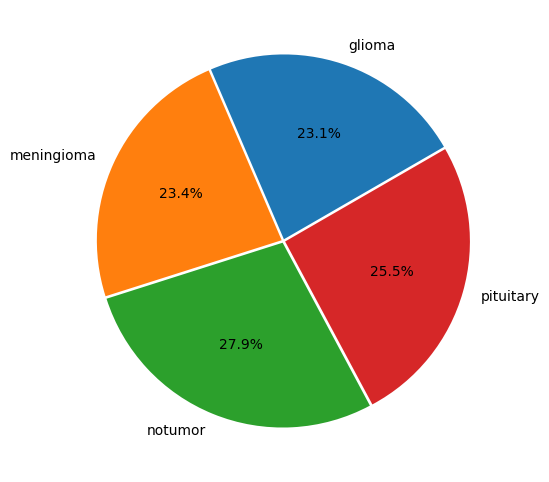

In [ ]:
plt.figure(figsize=(14,6))
plt.pie([len([x for x in train_labels if x==class_names[0]]),
         len([x for x in train_labels if x==class_names[1]]),
         len([x for x in train_labels if x==class_names[2]]),
         len([x for x in train_labels if x==class_names[3]])],
        labels=class_names,
        autopct='%.1f%%', explode=(0.01,0.01,0.01,0.01),
        startangle=30);

In [ ]:
len_train = len(train_labels)
len_test = len(test_labels)

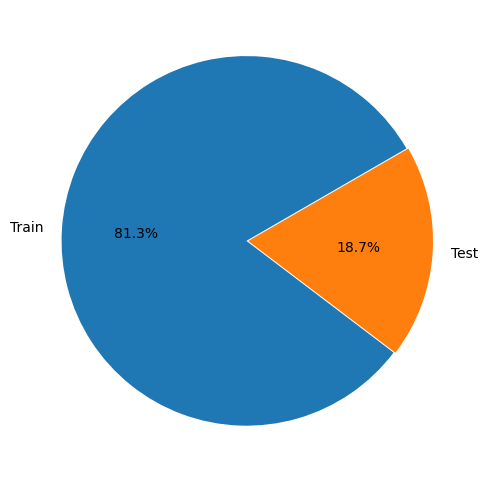

In [ ]:
plt.figure(figsize=(14,6))
plt.pie([len_train, len_test],
        labels=['Train','Test'], autopct='%.1f%%', explode=(0.01, 0),
        startangle=30);

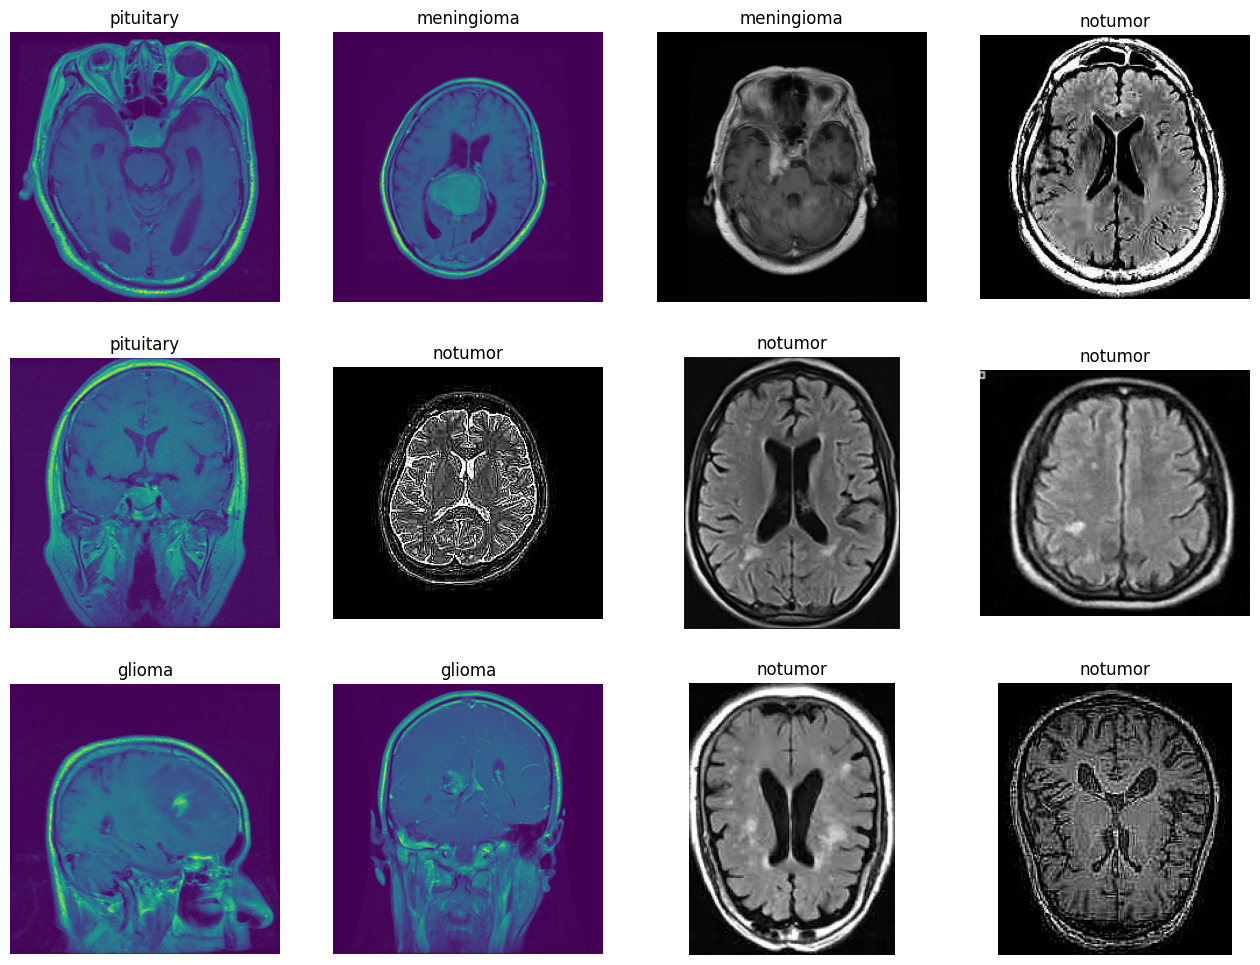

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows = 3
ncols = 4

pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 8

for i in range(0, 12):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')
  plt.title(train_labels[i])
  img = mpimg.imread(train_paths[i])
  plt.imshow(img)

plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                            rotation_range=0.2,
                                            shear_range=0.2,
                                            zoom_range=0.2,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            horizontal_flip=True,
                                            validation_split=0.2) # 20% de los datos para validación

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                subset='training',
                                                seed=42)

val_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                seed=42,
                                                shuffle=False,
                                                subset='validation')

test_data= test_datagen.flow_from_directory(test_dir,
                                            target_size=(224,224),
                                            batch_size=32,
                                            class_mode='categorical',
                                            seed=42,
                                            shuffle=False)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


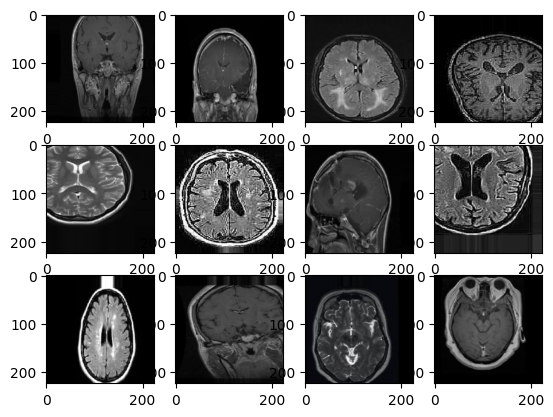

In [ ]:
#Observamos algunas imagenes con las transformaciones
for i in range(1,13):
  plt.subplot(3, 4, i)
  batch = train_data_augmented.next()
  image_ = batch[0][0]
  plt.imshow(image_)
plt.show()

In [ ]:
num_classes=len(class_names)
num_classes

4

# Experimento 1: Red Densa



In [ ]:
model_dense = Sequential()
model_dense.add(Flatten(input_shape=(224,224,3)))
model_dense.add(Dense(1024, activation='relu'))
model_dense.add(Dense(512, activation='relu'))
model_dense.add(Dense(224, activation='relu'))
model_dense.add(Dense(128, activation='relu'))
model_dense.add(Dense(num_classes, activation='softmax'))
model_dense.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model_dense.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 512)               77070848  
                                                                 
 dense_1 (Dense)             (None, 224)               114912    
                                                                 
 dense_2 (Dense)             (None, 128)               28800     
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 77215076 (294.55 MB)
Trainable params: 77215076 (294.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
epochs = 10
history_1 = model_dense.fit(train_data_augmented,
                        epochs=epochs,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=val_data_augmented,
                        validation_steps=len(val_data_augmented),
                        verbose=1)

Epoch 1/10
143/143 [==============================] - 95s 620ms/step - loss: 4.1298 - accuracy: 0.3111 - val_loss: 2.4336 - val_accuracy: 0.3216
Epoch 2/10
143/143 [==============================] - 83s 581ms/step - loss: 1.4924 - accuracy: 0.3767 - val_loss: 1.4834 - val_accuracy: 0.4119
Epoch 3/10
143/143 [==============================] - 85s 599ms/step - loss: 1.3547 - accuracy: 0.4010 - val_loss: 1.3391 - val_accuracy: 0.4347
Epoch 4/10
143/143 [==============================] - 85s 596ms/step - loss: 1.2428 - accuracy: 0.4327 - val_loss: 1.3535 - val_accuracy: 0.4820
Epoch 5/10
143/143 [==============================] - 108s 754ms/step - loss: 1.2019 - accuracy: 0.4599 - val_loss: 1.3002 - val_accuracy: 0.4803
Epoch 6/10
143/143 [==============================] - 83s 583ms/step - loss: 1.1732 - accuracy: 0.4625 - val_loss: 1.2789 - val_accuracy: 0.4969
Epoch 7/10
143/143 [==============================] - 83s 580ms/step - loss: 1.1553 - accuracy: 0.4802 - val_loss: 1.2492 - val_a

In [ ]:
def curvas(history_m):
  # Extraer los valores de loss y accuracy del historial
  loss = history_m.history['loss']
  val_loss = history_m.history['val_loss']
  accuracy = history_m.history['accuracy']
  val_accuracy = history_m.history['val_accuracy']

# Crear gráficos
  plt.figure(figsize=(6, 5))
# Gráfico de Accuracy
  plt.subplot(2, 1, 1)
  plt.plot(accuracy, label='Train Accuracy')
  plt.plot(val_accuracy, label='Validation Accuracy')
  plt.legend()
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid(True)
# Gráfico de Loss
  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Train Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend()
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)

  plt.tight_layout()
  plt.show()

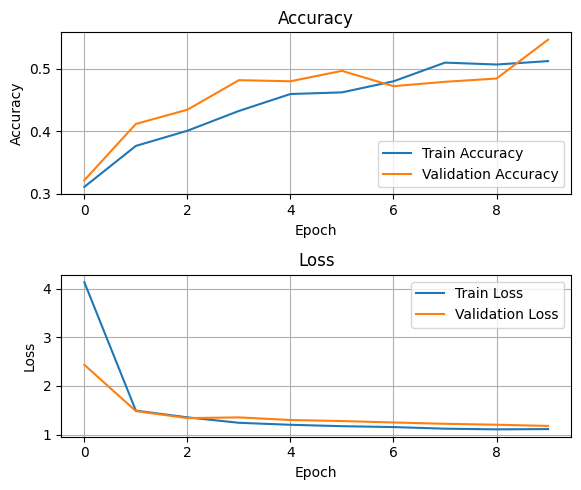

In [ ]:
curvas(history_1)

In [ ]:
train_data_augmented.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [ ]:
scores_1 = model_dense.evaluate(test_data)

print('Test loss:', round(scores_1[0],3))
print('Test accuracy:', round(scores_1[1],3))

all_results["acc"].append(round(scores_1[1],3))
all_results["loss"].append(round(scores_1[0],3))

41/41 [==============================] - 3s 81ms/step - loss: 1.2000 - accuracy: 0.5088
Test loss: 1.2
Test accuracy: 0.509


In [ ]:
y_test = test_data.labels
y_preds = model_dense.predict(test_data)
y_preds = np.argmax(y_preds, axis = 1)

41/41 [==============================] - 3s 73ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_preds, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.56      0.50      0.53       300
  meningioma       0.41      0.18      0.25       306
     notumor       0.82      0.47      0.60       405
   pituitary       0.40      0.90      0.55       300

    accuracy                           0.51      1311
   macro avg       0.55      0.51      0.48      1311
weighted avg       0.57      0.51      0.49      1311



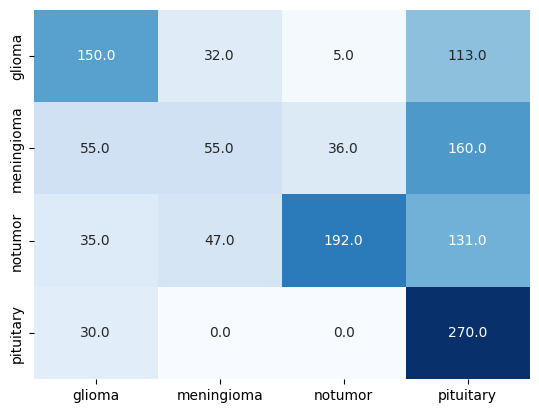

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true = y_test, y_pred = y_preds)
sns.heatmap(cf_matrix, annot=True, xticklabels=class_names, yticklabels = class_names,
            fmt='.1f', cbar=False, cmap='Blues');

# Experimento 2: Tiny VGG


In [ ]:
model_tiny = Sequential()
model_tiny.add(Conv2D(filters=10, kernel_size=(3,3), activation="relu", input_shape=(224,224,3)))
model_tiny.add(Conv2D(filters=10, kernel_size=(3,3), activation="relu"))
model_tiny.add(MaxPool2D())
model_tiny.add(Conv2D(filters=10, kernel_size=(3,3), activation="relu"))
model_tiny.add(Conv2D(filters=10, kernel_size=(3,3), activation="relu"))
model_tiny.add(MaxPool2D())
model_tiny.add(Flatten())
model_tiny.add(Dense(num_classes, activation='softmax'))
model_tiny.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model_tiny.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                 

In [ ]:
history_2 = model_tiny.fit(train_data_augmented,
                        epochs=epochs,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=val_data_augmented,
                        validation_steps=len(val_data_augmented),
                        verbose=1)

Epoch 1/10
143/143 [==============================] - 128s 833ms/step - loss: 0.9889 - accuracy: 0.5585 - val_loss: 1.0547 - val_accuracy: 0.6188
Epoch 2/10
143/143 [==============================] - 86s 600ms/step - loss: 0.8358 - accuracy: 0.6511 - val_loss: 1.0999 - val_accuracy: 0.5942
Epoch 3/10
143/143 [==============================] - 117s 820ms/step - loss: 0.8045 - accuracy: 0.6791 - val_loss: 1.0512 - val_accuracy: 0.6135
Epoch 4/10
143/143 [==============================] - 118s 830ms/step - loss: 0.7320 - accuracy: 0.7036 - val_loss: 0.9141 - val_accuracy: 0.6696
Epoch 5/10
143/143 [==============================] - 93s 655ms/step - loss: 0.7067 - accuracy: 0.7180 - val_loss: 0.8584 - val_accuracy: 0.6862
Epoch 6/10
143/143 [==============================] - 112s 779ms/step - loss: 0.6671 - accuracy: 0.7278 - val_loss: 0.8900 - val_accuracy: 0.6713
Epoch 7/10
143/143 [==============================] - 92s 645ms/step - loss: 0.6531 - accuracy: 0.7322 - val_loss: 0.9718 - va

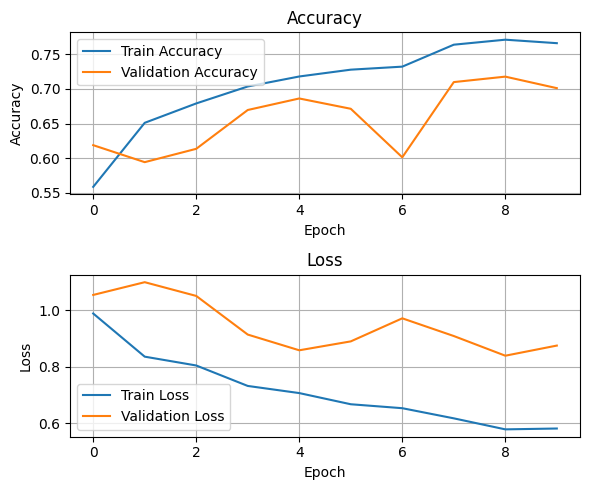

In [ ]:
curvas(history_2)

In [ ]:
scores_2 = model_tiny.evaluate(test_data)

print('Test loss:', round(scores_2[0],3))
print('Test accuracy:', round(scores_2[1],3))

all_results["acc"].append(round(scores_2[1],3))
all_results["loss"].append(round(scores_2[0],3))

41/41 [==============================] - 4s 92ms/step - loss: 0.9362 - accuracy: 0.7124
Test loss: 0.936
Test accuracy: 0.712


In [ ]:
y_test = test_data.labels
y_preds = model_tiny.predict(test_data)
y_preds = np.argmax(y_preds, axis = 1)

41/41 [==============================] - 3s 66ms/step


In [ ]:
print(classification_report(y_test, y_preds, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.91      0.45      0.60       300
  meningioma       0.59      0.44      0.50       306
     notumor       0.79      0.93      0.86       405
   pituitary       0.63      0.96      0.76       300

    accuracy                           0.71      1311
   macro avg       0.73      0.70      0.68      1311
weighted avg       0.73      0.71      0.69      1311



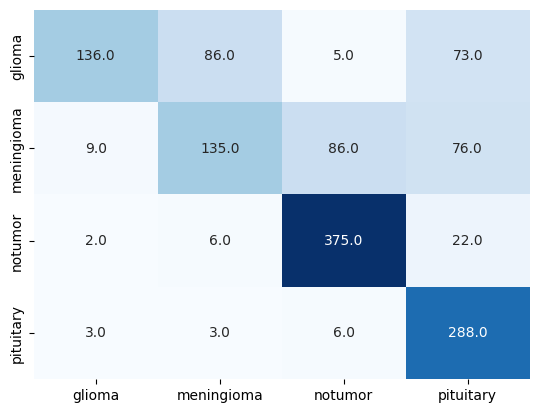

In [ ]:
cf_matrix = confusion_matrix(y_true = y_test, y_pred = y_preds)
sns.heatmap(cf_matrix, annot=True, xticklabels=class_names, yticklabels = class_names,
            fmt='.1f', cbar=False, cmap='Blues');

# Experimento 3: CNN



In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv2D(filters=10, kernel_size=(3,3), activation="relu", input_shape = (224,224,3)))
model_cnn.add(MaxPool2D(pool_size=2))
model_cnn.add(Conv2D(filters=10, kernel_size=(3,3), activation="relu"))
model_cnn.add(MaxPool2D())
model_cnn.add(Conv2D(filters=10, kernel_size=(3,3), activation="relu"))
model_cnn.add(MaxPool2D())
model_cnn.add(Conv2D(filters=10, kernel_size=(3,3), activation="relu"))
model_cnn.add(Conv2D(filters=10, kernel_size=(3,3), activation="relu"))
model_cnn.add(MaxPool2D())
model_cnn.add(Flatten())
model_cnn.add(Dense(num_classes, activation='softmax'))
model_cnn.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 26, 26, 10)       

In [ ]:
history_3 = model_cnn.fit(train_data_augmented,
                        epochs=epochs,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=val_data_augmented,
                        validation_steps=len(val_data_augmented),
                        verbose=1)

Epoch 1/10
143/143 [==============================] - 87s 594ms/step - loss: 1.1196 - accuracy: 0.4706 - val_loss: 1.1892 - val_accuracy: 0.5223
Epoch 2/10
143/143 [==============================] - 94s 659ms/step - loss: 0.9141 - accuracy: 0.6075 - val_loss: 1.0999 - val_accuracy: 0.5504
Epoch 3/10
143/143 [==============================] - 91s 639ms/step - loss: 0.8373 - accuracy: 0.6559 - val_loss: 1.0120 - val_accuracy: 0.6319
Epoch 4/10
143/143 [==============================] - 99s 695ms/step - loss: 0.8056 - accuracy: 0.6712 - val_loss: 1.0406 - val_accuracy: 0.6117
Epoch 5/10
143/143 [==============================] - 103s 722ms/step - loss: 0.7580 - accuracy: 0.6841 - val_loss: 0.9887 - val_accuracy: 0.6450
Epoch 6/10
143/143 [==============================] - 103s 720ms/step - loss: 0.7546 - accuracy: 0.6933 - val_loss: 0.9186 - val_accuracy: 0.6792
Epoch 7/10
143/143 [==============================] - 92s 642ms/step - loss: 0.7344 - accuracy: 0.6998 - val_loss: 1.0044 - val_

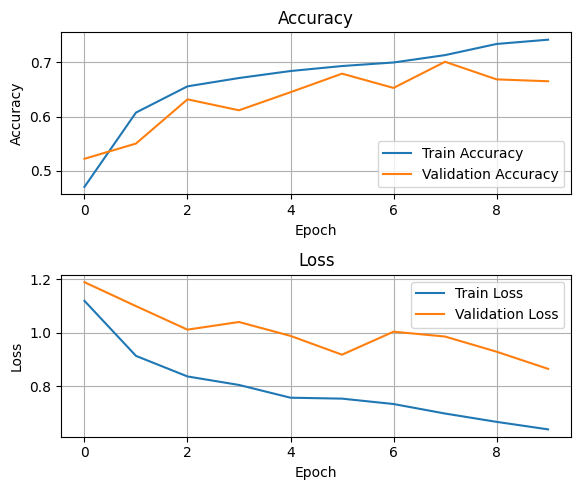

In [ ]:
curvas(history_3)

In [ ]:
scores_3 = model_cnn.evaluate(test_data)

print('Test loss:', round(scores_3[0],3))
print('Test accuracy:', round(scores_3[1],3))

all_results["acc"].append(round(scores_3[1],3))
all_results["loss"].append(round(scores_3[0],3))

41/41 [==============================] - 5s 119ms/step - loss: 0.7835 - accuracy: 0.7353
Test loss: 0.784
Test accuracy: 0.735


In [ ]:
y_test = test_data.labels
y_preds = model_cnn.predict(test_data)
y_preds = np.argmax(y_preds, axis = 1)
print(classification_report(y_test, y_preds, target_names=class_names))

41/41 [==============================] - 4s 91ms/step
              precision    recall  f1-score   support

      glioma       0.81      0.61      0.70       300
  meningioma       0.59      0.42      0.49       306
     notumor       0.80      0.90      0.85       405
   pituitary       0.70      0.95      0.81       300

    accuracy                           0.74      1311
   macro avg       0.72      0.72      0.71      1311
weighted avg       0.73      0.74      0.72      1311



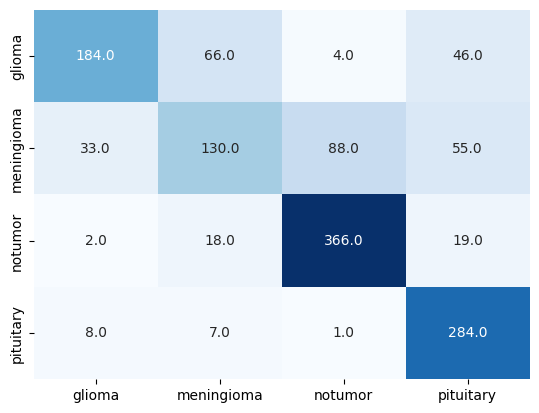

In [ ]:
cf_matrix = confusion_matrix(y_true = y_test, y_pred = y_preds)
sns.heatmap(cf_matrix, annot=True, xticklabels=class_names, yticklabels = class_names,
            fmt='.1f', cbar=False, cmap='Blues');

# Experimento 4: Transfer Learning EfficientNetB0

In [ ]:
from tensorflow.keras import layers
import keras
from tensorflow.keras.applications import EfficientNetB0
# Crear el modelo usando la api funcional de Keras
input_shape = (224,224,3)
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
effnet.trainable = False
inputs = keras.Input(shape=input_shape)
x = effnet(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = tf.keras.layers.Dropout(rate=0.5)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model_TLE = tf.keras.models.Model(inputs, outputs)

model_TLE.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model_TLE.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_6  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 4)                 5124      
                                                                 
Total params: 4054695 (15.47 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


In [ ]:
checkpoint_path = "model_checkpoint/checkpoint.ckpt"
# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         monitor="val_accuracy",
                                                         verbose=0)

In [ ]:
history_4=[]
history_4 = model_TLE.fit(train_data_augmented,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=val_data_augmented,
                        validation_steps=len(val_data_augmented),
                        callbacks = [checkpoint_callback],
                        verbose=1)

Epoch 1/5
143/143 [==============================] - 100s 658ms/step - loss: 1.3976 - accuracy: 0.2669 - val_loss: 1.3945 - val_accuracy: 0.2314
Epoch 2/5
143/143 [==============================] - 84s 589ms/step - loss: 1.3918 - accuracy: 0.2759 - val_loss: 1.3906 - val_accuracy: 0.2796
Epoch 3/5
143/143 [==============================] - 85s 594ms/step - loss: 1.3791 - accuracy: 0.2993 - val_loss: 1.3811 - val_accuracy: 0.2796
Epoch 4/5
143/143 [==============================] - 82s 571ms/step - loss: 1.3751 - accuracy: 0.3152 - val_loss: 1.3810 - val_accuracy: 0.2507
Epoch 5/5
143/143 [==============================] - 82s 571ms/step - loss: 1.3747 - accuracy: 0.2901 - val_loss: 1.3756 - val_accuracy: 0.2796


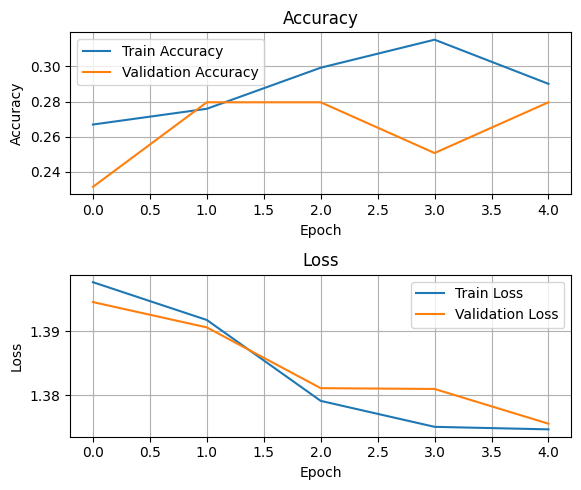

In [ ]:
curvas(history_4)

In [ ]:
#all_results['acc'] = all_results['acc'][:-1]
#all_results['loss'] = all_results['loss'][:-1]

In [ ]:
scores_4 = model_TLE.evaluate(test_data)

print('Test loss:', round(scores_4[0],3))
print('Test accuracy:', round(scores_4[1],3))

all_results["acc"].append(round(scores_4[1],3))
all_results["loss"].append(round(scores_4[0],3))

41/41 [==============================] - 3s 80ms/step - loss: 1.3547 - accuracy: 0.3089
Test loss: 1.355
Test accuracy: 0.309


In [ ]:
y_test = test_data.labels
y_preds = model_TLE.predict(test_data)
y_preds = np.argmax(y_preds, axis = 1)
print(classification_report(y_test, y_preds, target_names=class_names))

41/41 [==============================] - 6s 112ms/step
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.00      0.00      0.00       306
     notumor       0.31      1.00      0.47       405
   pituitary       0.00      0.00      0.00       300

    accuracy                           0.31      1311
   macro avg       0.08      0.25      0.12      1311
weighted avg       0.10      0.31      0.15      1311



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


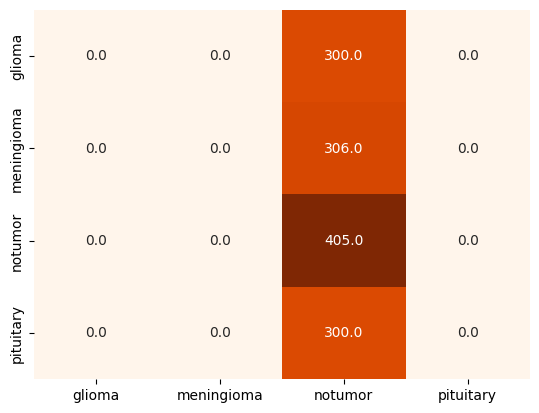

In [ ]:
cf_matrix = confusion_matrix(y_true = y_test, y_pred = y_preds)
sns.heatmap(cf_matrix, annot=True, xticklabels=class_names, yticklabels = class_names,
            fmt='.1f', cbar=False, cmap='Oranges');

# Experimento 5: Transfer Learning + Fine-tuning EfficientNetB0

In [ ]:
for layer in model_TLE.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7da5a03864d0> True
<keras.src.engine.functional.Functional object at 0x7da5bf0068c0> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7da5bf35efe0> True
<keras.src.layers.core.dense.Dense object at 0x7da5bf343e20> True


In [ ]:
effnet.trainable = True
print("Capas que se pueden entrenar en total: ")
print(len(model_TLE.layers[1].trainable_variables))
# Congelar todas las capas excepto las ultimas 35 capasS
for layer in effnet.layers[:-35]:
  layer.trainable = False

print("Capas que se pueden entrenar al limitar: ")
print(len(model_TLE.layers[1].trainable_variables))

Capas que se pueden entrenar en total: 
211
Capas que se pueden entrenar al limitar: 
32


In [ ]:
model_TLE.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model_TLE.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_6  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 4)                 5124      
                                                                 
Total params: 4054695 (15.47 MB)
Trainable params: 2055828 (7.84 MB)
Non-trainable params: 1998867 (7.63 MB)
_________________________________________________________________


In [ ]:
# verficar cuales capas son entrenables
for i, layer in enumerate(model_TLE.layers[1].layers):
  if (layer.trainable):
    print(i, layer.name, layer.trainable)

203 block6c_project_conv True
204 block6c_project_bn True
205 block6c_drop True
206 block6c_add True
207 block6d_expand_conv True
208 block6d_expand_bn True
209 block6d_expand_activation True
210 block6d_dwconv True
211 block6d_bn True
212 block6d_activation True
213 block6d_se_squeeze True
214 block6d_se_reshape True
215 block6d_se_reduce True
216 block6d_se_expand True
217 block6d_se_excite True
218 block6d_project_conv True
219 block6d_project_bn True
220 block6d_drop True
221 block6d_add True
222 block7a_expand_conv True
223 block7a_expand_bn True
224 block7a_expand_activation True
225 block7a_dwconv True
226 block7a_bn True
227 block7a_activation True
228 block7a_se_squeeze True
229 block7a_se_reshape True
230 block7a_se_reduce True
231 block7a_se_expand True
232 block7a_se_excite True
233 block7a_project_conv True
234 block7a_project_bn True
235 top_conv True
236 top_bn True
237 top_activation True


In [ ]:
history_5 = model_TLE.fit(train_data_augmented,
                        epochs=epochs,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=val_data_augmented,
                        validation_steps=len(val_data_augmented),
                        callbacks = [checkpoint_callback],
                        initial_epoch = history_4.epoch[-1],
                        verbose=1)

Epoch 5/10
143/143 [==============================] - 98s 609ms/step - loss: 1.3686 - accuracy: 0.3104 - val_loss: 1.4468 - val_accuracy: 0.2594
Epoch 6/10
143/143 [==============================] - 93s 650ms/step - loss: 1.3152 - accuracy: 0.3380 - val_loss: 1.3233 - val_accuracy: 0.3646
Epoch 7/10
143/143 [==============================] - 87s 604ms/step - loss: 1.2315 - accuracy: 0.3835 - val_loss: 1.2852 - val_accuracy: 0.3304
Epoch 8/10
143/143 [==============================] - 106s 744ms/step - loss: 1.2187 - accuracy: 0.3837 - val_loss: 1.3605 - val_accuracy: 0.3427
Epoch 9/10
143/143 [==============================] - 119s 834ms/step - loss: 1.1986 - accuracy: 0.3916 - val_loss: 1.2881 - val_accuracy: 0.3839
Epoch 10/10
143/143 [==============================] - 97s 676ms/step - loss: 1.1709 - accuracy: 0.4181 - val_loss: 1.4122 - val_accuracy: 0.2761


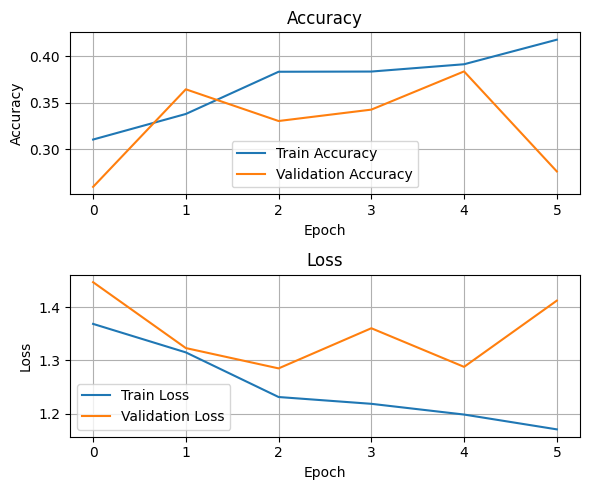

In [ ]:
curvas(history_5)

In [ ]:
scores_5 = model_TLE.evaluate(test_data)

print('Test loss:', round(scores_5[0],3))
print('Test accuracy:', round(scores_5[1],3))

all_results["acc"].append(round(scores_5[1],3))
all_results["loss"].append(round(scores_5[0],3))

41/41 [==============================] - 5s 111ms/step - loss: 1.6101 - accuracy: 0.3021
Test loss: 1.61
Test accuracy: 0.302


In [ ]:
y_test = test_data.labels
y_preds = model_TLE.predict(test_data)
y_preds = np.argmax(y_preds, axis = 1)
print(classification_report(y_test, y_preds, target_names=class_names))

41/41 [==============================] - 5s 82ms/step
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.14      0.01      0.02       306
     notumor       0.31      0.96      0.46       405
   pituitary       0.20      0.01      0.01       300

    accuracy                           0.30      1311
   macro avg       0.16      0.25      0.13      1311
weighted avg       0.17      0.30      0.15      1311



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


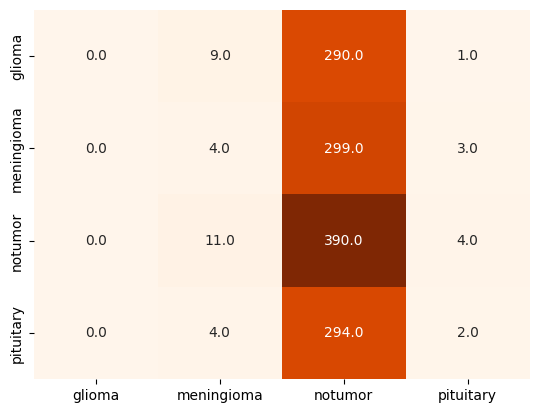

In [ ]:
cf_matrix = confusion_matrix(y_true = y_test, y_pred = y_preds)
sns.heatmap(cf_matrix, annot=True, xticklabels=class_names, yticklabels = class_names,
            fmt='.1f', cbar=False, cmap='Oranges');

# Resultados

In [ ]:
df_results = pd.DataFrame.from_dict(all_results)
df_results

,models,acc,loss
0,Red_Densa,0.509,1.200
1,TinyVGG,0.712,0.936
2,CNN,0.735,0.784
3,TransferEfficientNetB0,0.309,1.355
4,TransferEfficientNetB0_Fine_tuning,0.302,1.610


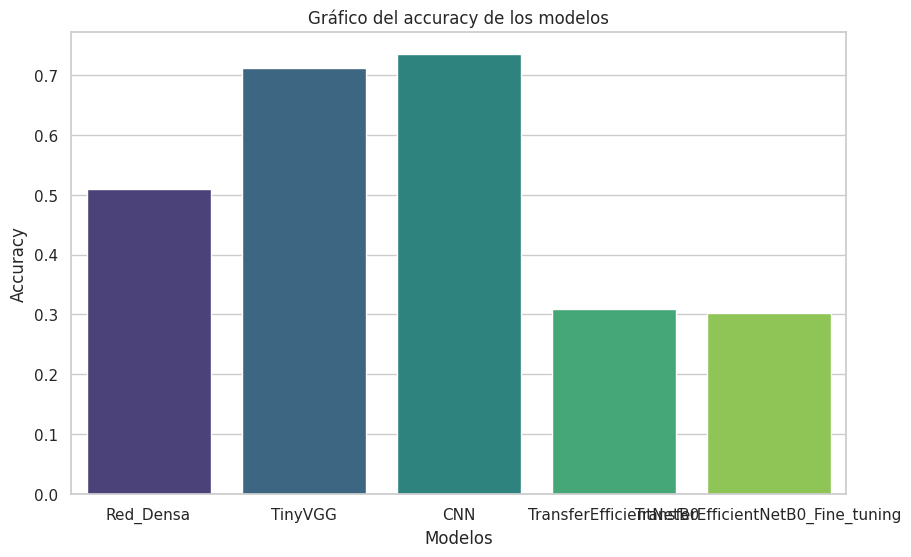

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='models', y='acc', data=df_results, palette='viridis')
bar_plot.set(xlabel='Modelos', ylabel='Accuracy', title='Gráfico del accuracy de los modelos')
plt.show()

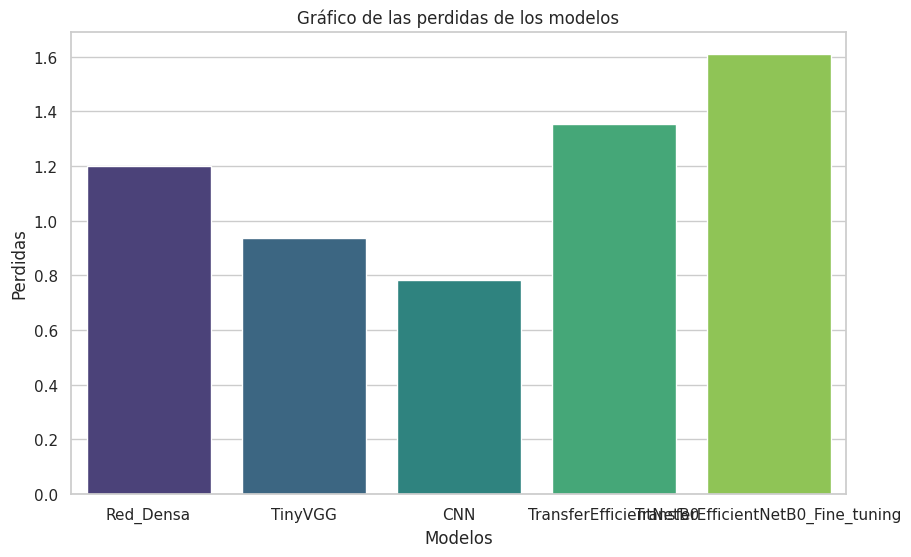

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='models', y='loss', data=df_results, palette='viridis')
bar_plot.set(xlabel='Modelos', ylabel='Perdidas', title='Gráfico de las perdidas de los modelos')
plt.show()

# Modelo VGG16 pero entrenando todas sus capas

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import *
import keras
input_shape = (224,224,3)
base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model_TLE_all = Sequential()
model_TLE_all.add(keras.Input(shape=input_shape))
model_TLE_all.add(base_model)
model_TLE_all.add(Flatten())
model_TLE_all.add(Dropout(0.3))
model_TLE_all.add(Dense(128, activation='relu'))
model_TLE_all.add(Dropout(0.2))
model_TLE_all.add(Dense(num_classes, activation='softmax'))
model_TLE_all.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.0001,
                              mode='auto',verbose=1)

In [ ]:
history_TLE_all = []
history_TLE_all = model_TLE_all.fit(train_data_augmented,
                        epochs=15,
                        batch_size = 32,
                        validation_data=val_data_augmented,
                        callbacks = [reduce_lr],
                        verbose=1)

Epoch 1/15
143/143 [==============================] - 98s 663ms/step - loss: 0.6482 - accuracy: 0.7303 - val_loss: 0.7253 - val_accuracy: 0.7230 - lr: 1.0000e-04
Epoch 2/15
143/143 [==============================] - 90s 630ms/step - loss: 0.3164 - accuracy: 0.8779 - val_loss: 0.5494 - val_accuracy: 0.8186 - lr: 1.0000e-04
Epoch 3/15
143/143 [==============================] - 109s 758ms/step - loss: 0.2317 - accuracy: 0.9162 - val_loss: 0.3716 - val_accuracy: 0.8589 - lr: 1.0000e-04
Epoch 4/15
143/143 [==============================] - 90s 631ms/step - loss: 0.1884 - accuracy: 0.9317 - val_loss: 0.3641 - val_accuracy: 0.8738 - lr: 1.0000e-04
Epoch 5/15
143/143 [==============================] - 89s 625ms/step - loss: 0.1515 - accuracy: 0.9447 - val_loss: 0.3997 - val_accuracy: 0.8799 - lr: 1.0000e-04
Epoch 6/15
143/143 [==============================] - 92s 640ms/step - loss: 0.1279 - accuracy: 0.9587 - val_loss: 0.3420 - val_accuracy: 0.9036 - lr: 1.0000e-04
Epoch 7/15
143/143 [=======

In [ ]:
scores = model_TLE_all.evaluate(test_data)

print('Test loss:', round(scores[0],3))
print('Test accuracy:', round(scores[1],3))

41/41 [==============================] - 9s 222ms/step - loss: 0.2568 - accuracy: 0.9504
Test loss: 0.257
Test accuracy: 0.95


In [ ]:
y_test = test_data.labels
y_preds = model_TLE_all.predict(test_data)
y_preds = np.argmax(y_preds, axis = 1)
print(classification_report(y_test, y_preds, target_names=class_names))

41/41 [==============================] - 6s 149ms/step
              precision    recall  f1-score   support

      glioma       0.97      0.90      0.94       300
  meningioma       0.95      0.90      0.93       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.88      1.00      0.94       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



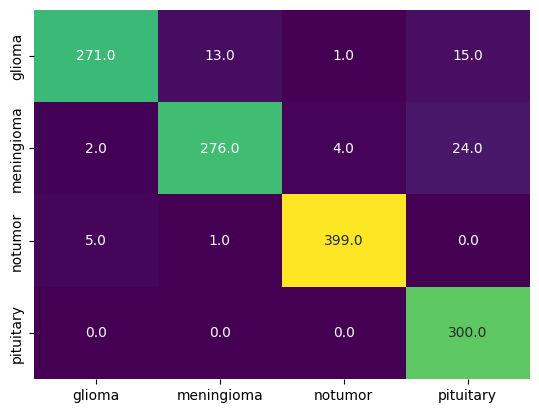

In [ ]:
cf_matrix = confusion_matrix(y_true = y_test, y_pred = y_preds)
sns.heatmap(cf_matrix, annot=True, xticklabels=class_names, yticklabels = class_names,
            fmt='.1f', cbar=False, cmap='viridis');

# Prueba del ultimo modelo

Saving Te-gl_0010.jpg to Te-gl_0010.jpg
Saving Te-me_0010.jpg to Te-me_0010 (2).jpg
Saving Te-no_0010.jpg to Te-no_0010.jpg
Saving Te-pi_0010.jpg to Te-pi_0010.jpg
1/1 [==============================] - 0s 18ms/step
Te-gl_0010.jpg


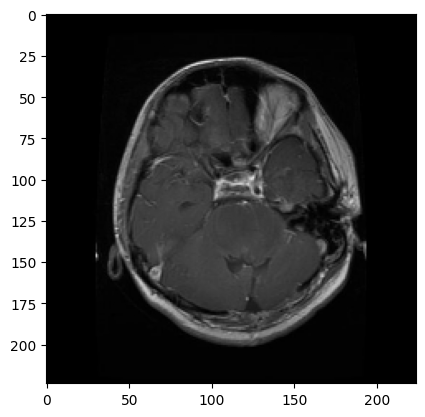

[[9.8979139e-01 2.8615716e-06 4.1703611e-06 1.0201531e-02]]
Es un glioma
1/1 [==============================] - 0s 25ms/step
Te-me_0010 (2).jpg


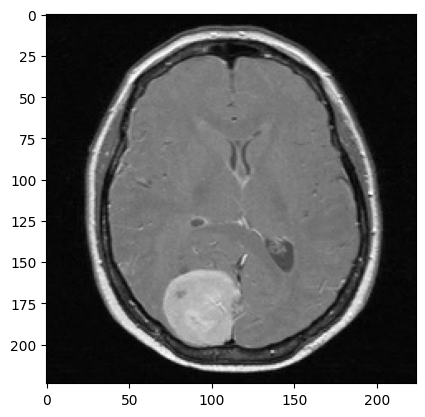

[[9.5665274e-11 9.9869031e-01 1.3077422e-03 1.9633264e-06]]
Es un meningioma
1/1 [==============================] - 0s 26ms/step
Te-no_0010.jpg


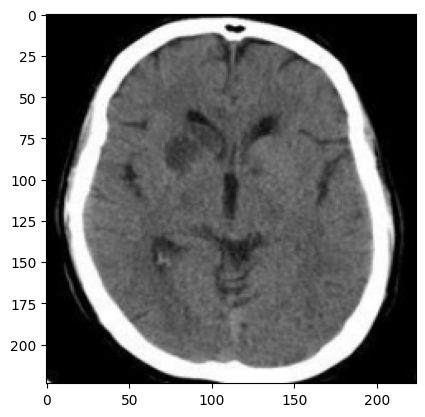

[[1.8717263e-12 5.0003710e-08 1.0000000e+00 1.7004476e-11]]
No es un tumor
1/1 [==============================] - 0s 34ms/step
Te-pi_0010.jpg


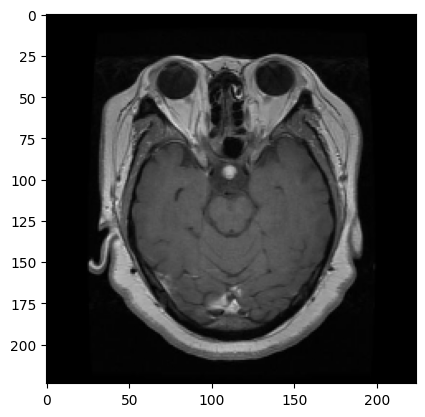

[[8.7429722e-13 1.4535832e-10 8.5447757e-13 1.0000000e+00]]
Es un pituitary


In [ ]:
import numpy as np
from google.colab import files
import tensorflow as tf
import matplotlib.image as mpimg

uploaded = files.upload()
for fn in uploaded.keys():
  path = fn
  x = mpimg.imread(fn)
  x = tf.image.resize(x, size=[224, 224])
  x = tf.cast(x, dtype=tf.float32)
  x = x/255.
  x_e = tf.expand_dims(x, axis = 0)
# {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
  classes = model_TLE_all.predict(x_e)
  y_preds = np.argmax(classes, axis = 1)
  print(fn)
  plt.imshow(x)
  plt.show()
  print(classes)
  if y_preds==0:
    print("Es un glioma")
  if y_preds==1:
    print("Es un meningioma")
  if y_preds==2:
    print("No es un tumor")
  if y_preds==3:
    print("Es un pituitary")